1. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, accuracy_score,
                            precision_score, recall_score, f1_score,
                            confusion_matrix)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Feature selection optimization
!pip install deap pyswarms  # Install if not already present
from deap import base, creator, tools, algorithms
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 18.5 MB/s eta 0:00:00


2. Load & Preprocess Data

In [2]:
def load_data(train_path, test_path):
    # Load datasets (skip metadata rows)
    train_df = pd.read_csv(train_path, skiprows=20)
    test_df = pd.read_csv(test_path, skiprows=20)
    return train_df, test_df

def preprocess_data(train_df, test_df):
    # Replace 'na' with NaN
    train_df.replace('na', np.nan, inplace=True)
    test_df.replace('na', np.nan, inplace=True)

    # Encode target labels ('neg'=0, 'pos'=1)
    le = LabelEncoder()
    train_df['class'] = le.fit_transform(train_df['class'])
    test_df['class'] = le.transform(test_df['class'])

    # Split features & labels
    X_train = train_df.drop('class', axis=1).astype(float)
    y_train = train_df['class']
    X_test = test_df.drop('class', axis=1).astype(float)
    y_test = test_df['class']

    # Impute missing values (mean imputation)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test

# Load & preprocess
train_path = '/content/sample_data/aps_failure_training_set.csv'
test_path = '/content/sample_data/aps_failure_test_set.csv'
train_df, test_df = load_data(train_path, test_path)
X_train, y_train, X_test, y_test = preprocess_data(train_df, test_df)

3. Feature Selection

Genetic Algorithm (GA)


In [3]:
def run_genetic_algorithm(X_train, y_train, X_test, y_test):
    # Initialize DEAP structures
    if "FitnessMax" not in creator.__dict__:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if "Individual" not in creator.__dict__:
        creator.create("Individual", list, fitness=creator.FitnessMax)

    # Setup GA
    n_features = X_train.shape[1]
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Fitness function (maximize F1-score)
    def ga_fitness(individual):
        selected = [i for i, bit in enumerate(individual) if bit == 1]
        if len(selected) < 5:  # Skip if too few features
            return 0.0,
        clf = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)
        clf.fit(X_train[:, selected], y_train)
        preds = clf.predict(X_test[:, selected])
        return f1_score(y_test, preds),

    # Configure GA operations
    toolbox.register("evaluate", ga_fitness)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=2)

    # Run GA
    pop = toolbox.population(n=10)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=False)

    # Extract best solution
    best_ind = tools.selBest(pop, 1)[0]
    selected_indices = [i for i, bit in enumerate(best_ind) if bit == 1]
    print(f"GA selected {len(selected_indices)} features out of {n_features}.")
    return selected_indices

ga_selected_indices = run_genetic_algorithm(X_train, y_train, X_test, y_test)

GA selected 84 features out of 170.


Particle Swarm Optimization (PSO)


In [4]:
def run_pso(X_train, y_train, X_test, y_test):
    # Fitness function (minimize negative F1)
    def pso_fitness(particles):
        scores = []
        for particle in particles:
            selected = [i for i, bit in enumerate(particle) if bit > 0.5]
            if len(selected) < 5:
                scores.append(0.0)
                continue
            clf = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)
            clf.fit(X_train[:, selected], y_train)
            preds = clf.predict(X_test[:, selected])
            scores.append(f1_score(y_test, preds))
        return -np.array(scores)  # PSO minimizes, so invert F1

    # PSO configuration
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
    dimensions = X_train.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=dimensions, options=options)

    # Run PSO
    cost, pos = optimizer.optimize(pso_fitness, iters=10)
    selected_indices = [i for i in range(len(pos)) if pos[i] > 0.5]
    print(f"PSO selected {len(selected_indices)} features out of {dimensions}.")
    return selected_indices

pso_selected_indices = run_pso(X_train, y_train, X_test, y_test)

2025-05-17 16:46:29,628 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=-0.696
2025-05-17 16:51:15,169 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -0.6955074875207987, best pos: [1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1
 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0]


PSO selected 110 features out of 170.


4. Model Training & Evaluation

In [5]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds),
        'ConfusionMatrix': confusion_matrix(y_test, preds)
    }

# Define models
models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Evaluate all models
def evaluate_all_models(models, X_train, y_train, X_test, y_test, ga_indices, pso_indices):
    results = []
    conf_matrices = {}

    for name, model in models.items():
        # All features
        res_all = evaluate_model(f'{name} - All Features', model, X_train, y_train, X_test, y_test)
        results.append({k: v for k, v in res_all.items() if k != 'ConfusionMatrix'})
        conf_matrices[f'{name} - All Features'] = res_all['ConfusionMatrix']

        # GA-selected features
        res_ga = evaluate_model(f'{name} - GA Selected', model, X_train[:, ga_indices], y_train, X_test[:, ga_indices], y_test)
        results.append({k: v for k, v in res_ga.items() if k != 'ConfusionMatrix'})
        conf_matrices[f'{name} - GA Selected'] = res_ga['ConfusionMatrix']

        # PSO-selected features
        res_pso = evaluate_model(f'{name} - PSO Selected', model, X_train[:, pso_indices], y_train, X_test[:, pso_indices], y_test)
        results.append({k: v for k, v in res_pso.items() if k != 'ConfusionMatrix'})
        conf_matrices[f'{name} - PSO Selected'] = res_pso['ConfusionMatrix']

    return pd.DataFrame(results), conf_matrices

# Run evaluations
results_df, conf_matrices = evaluate_all_models(
    models, X_train, y_train, X_test, y_test,
    ga_selected_indices, pso_selected_indices
)

5. Visualization & Results


Top 84 features selected by Genetic Algorithm:
['aa_000', 'ae_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_006', 'ag_007', 'ag_008', 'ak_000', 'al_000', 'am_0', 'an_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'ax_000', 'ay_001', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'az_000', 'az_001', 'az_004', 'az_006', 'az_008', 'ba_001', 'ba_002', 'ba_004', 'ba_008', 'bc_000', 'bd_000', 'bf_000', 'bg_000', 'bk_000', 'bn_000', 'bp_000', 'bs_000', 'bv_000', 'bx_000', 'cb_000', 'cc_000', 'cf_000', 'ch_000', 'ci_000', 'cj_000', 'cl_000', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_005', 'cn_007', 'cn_008', 'cn_009', 'cp_000', 'cr_000', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_008', 'cs_009', 'cz_000', 'da_000', 'de_000', 'dg_000', 'dh_000', 'dj_000', 'dk_000', 'dm_000', 'du_000', 'dv_000', 'dx_000', 'dy_000', 'eb_000', 'ed_000', 'ee_005', 'ee_008']

Top 110 features selected by Particle Swarm Optimization:
['aa_000', 'ac_000', 'ad_000', 'ae_000', 'ag_001', 'ag

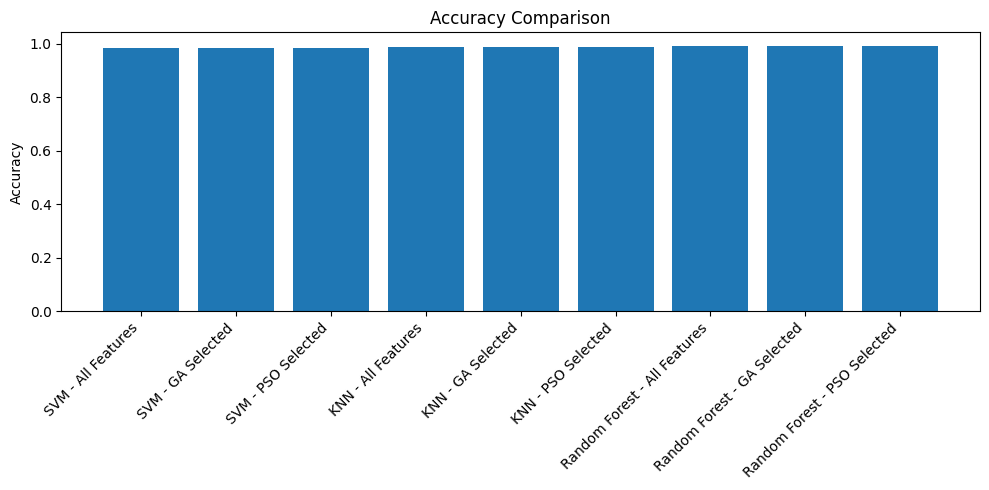

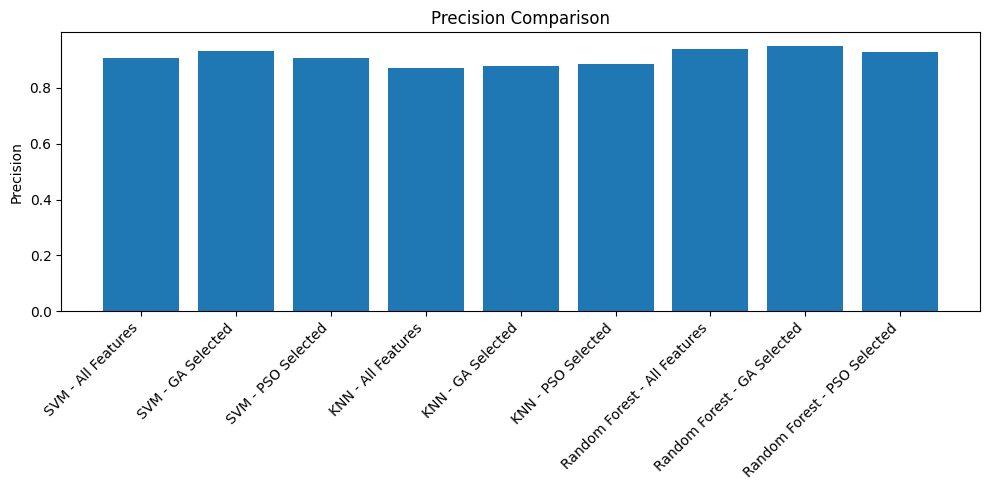

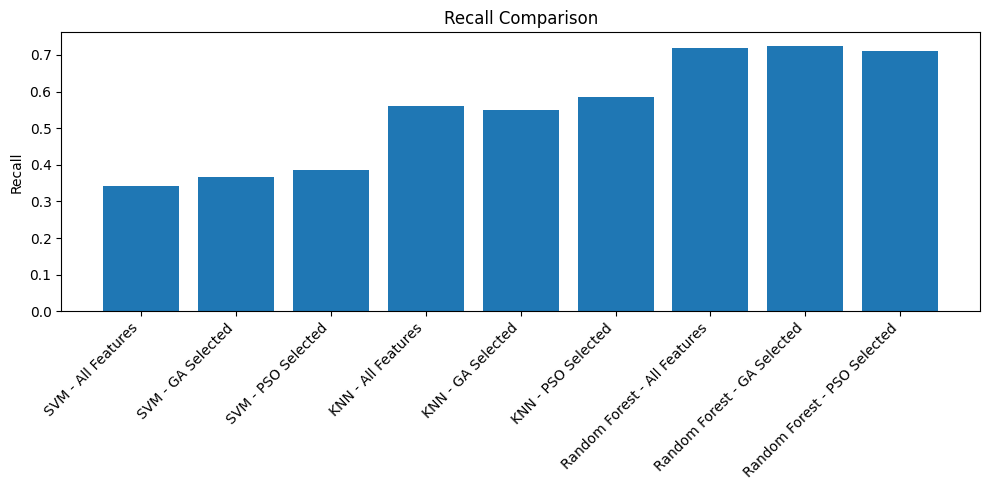

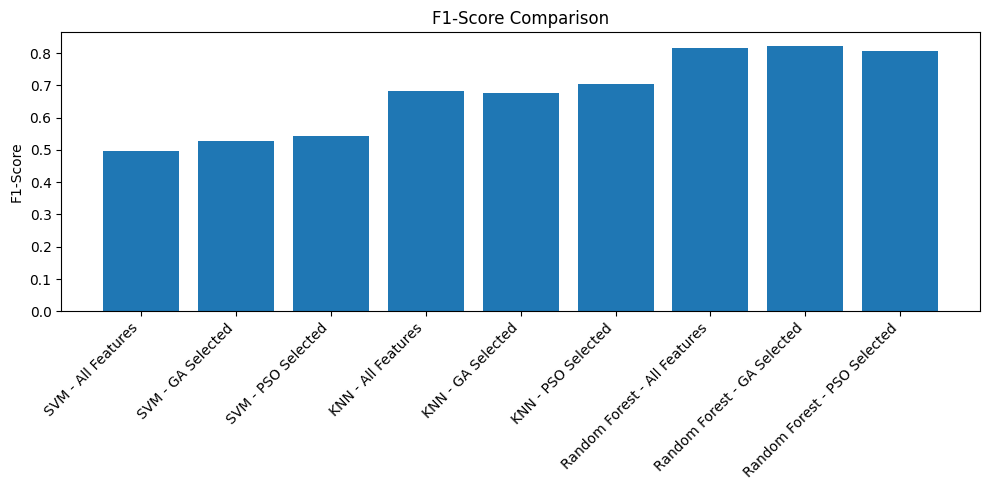

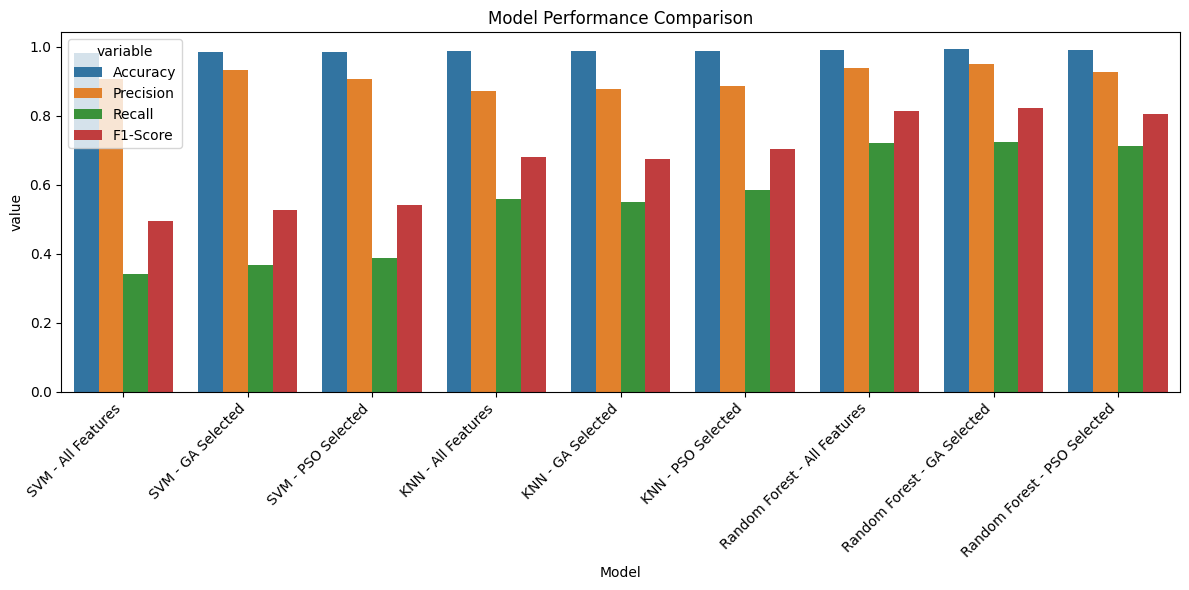

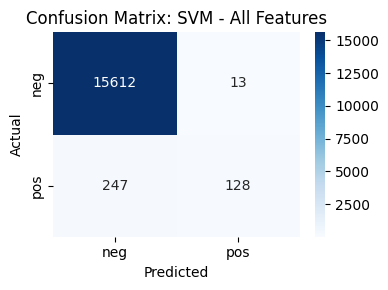

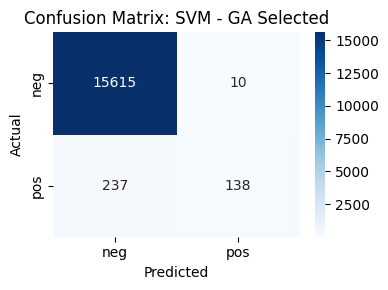

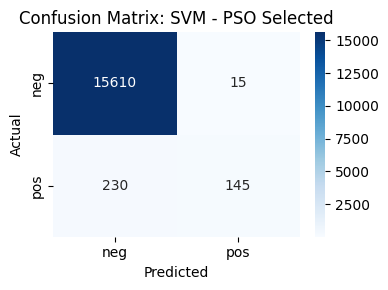

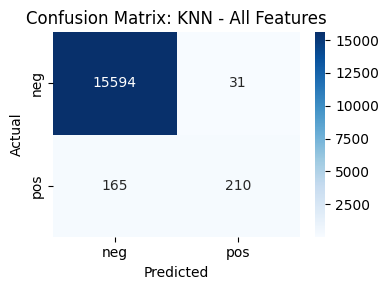

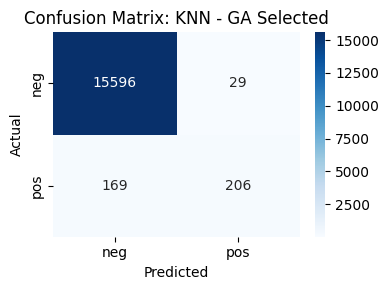

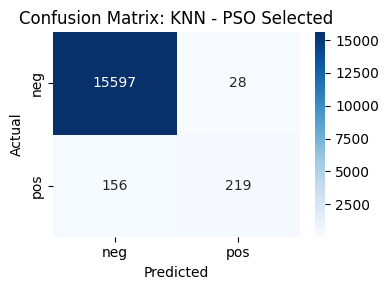

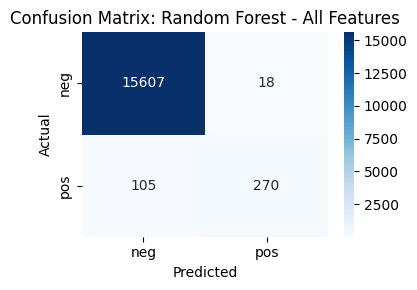

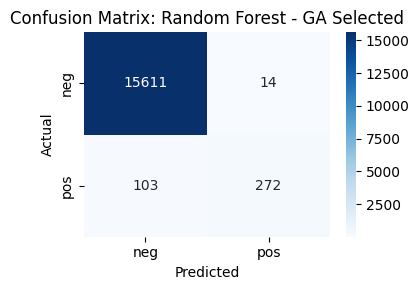

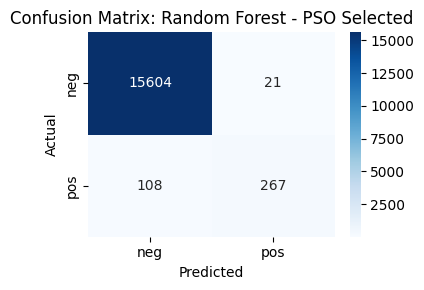

In [6]:
def visualize_results(results_df, conf_matrices):
    # Plot metrics comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        plt.bar(results_df['Model'], results_df[metric])
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison')
        plt.tight_layout()
        plt.show()

    # Combined metrics plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
    plt.title("Model Performance Comparison")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Confusion matrices
    for label, cm in conf_matrices.items():
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
        plt.title(f'Confusion Matrix: {label}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

# Display selected features
def print_top_features(selected_indices, name, feature_names):
    print(f"\nTop {len(selected_indices)} features selected by {name}:")
    print([feature_names[i] for i in selected_indices])

feature_names = list(train_df.columns[1:])  # Exclude 'class'
print_top_features(ga_selected_indices, "Genetic Algorithm", feature_names)
print_top_features(pso_selected_indices, "Particle Swarm Optimization", feature_names)

# Show final results
print("\n=== Final Results ===")
print(results_df)
visualize_results(results_df, conf_matrices)